In [1]:
import torch
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR, SequentialLR
import numpy as np
import matplotlib.pyplot as plt

from models import *
from my_datasets import *

device = "cuda" if torch.cuda.is_available() else "cpu"
saveto_dir = "_saved_models"

In [2]:
def train_model(model, dataloader, optimizer, lr_scheduler, tick=10):
    model.train().to(device)
    all_losses, all_elems_accs, all_state_accs = [], [], []
    pbar = tqdm(dataloader)
    for i, batch in enumerate(pbar):
        tokens, labels = batch["tokens"].to(device), batch["labels"].to(device)
        out = model(tokens, labels=labels)
        loss = out.loss
        loss.backward(); optimizer.step(); optimizer.zero_grad(); lr_scheduler.step()

        # Track stuff
        pred = (out.logits > 0).long()
        all_elems_accs.append((pred == labels).float().mean().cpu().item())
        all_state_accs.append((pred == labels).all(dim=-1).float().mean().cpu().item())
        all_losses.append(loss.detach().cpu().item())
        if (i+1) % tick == 0:
            avg_loss = torch.tensor(all_losses)[-tick:].mean().item()
            avg_elems_acc = torch.tensor(all_elems_accs)[-tick:].mean().item()
            avg_state_acc = torch.tensor(all_state_accs)[-tick:].mean().item()
            pbar.set_description(
                f"loss {avg_loss:.3f}, elem {avg_elems_acc:.3f}, state {avg_state_acc:.3f}"
            )
    
    return {
        "model": model,
        "losses": all_losses,
        "elems_accs": all_elems_accs,
        "state_accs": all_state_accs,
    }

In [3]:
def init_and_train_stuff(num_props, do_layer_norm, num_autoreg_steps, batch_size, num_optim_steps, lr):
    model = MyTheoryARModel(num_props, num_autoreg_steps, do_layer_norm=do_layer_norm)
    dataset = AutoregCustomTokensDataset(num_props, batch_size*num_optim_steps)
    dataloader = DataLoader(dataset, batch_size)
    optimizer = AdamW(model.parameters(), lr=lr)

    warmup_steps = int(0.1*num_optim_steps)
    lr_scheduler = SequentialLR(
        optimizer,
        schedulers = [
            LinearLR(optimizer, 0.01, 1.0, warmup_steps),
            LinearLR(optimizer, 1.0, 0.01, num_optim_steps - warmup_steps),
        ],
        milestones = [warmup_steps]
    )

    ret = train_model(model, dataloader, optimizer, lr_scheduler)
    return ret

In [4]:
num_autoreg_steps = 3
batch_size = 512
num_optim_steps = 8192
lr = 5e-4

In [5]:
# Modify this line to run the train stuff
if False:
    for num_props in [16, 32, 48, 64]:
        for do_layer_norm in [False, True]:
            ln_str = "1" if do_layer_norm else "0"
            saveto = f"theory_n{num_props}_ln{ln_str}_ar{num_autoreg_steps}_bsz{batch_size}_ns{num_optim_steps}_lr{lr:.4f}.pt"
            print(f"Running: {saveto}")
            ret = init_and_train_stuff(
                num_props = num_props,
                do_layer_norm = do_layer_norm,
                num_autoreg_steps = num_autoreg_steps,
                batch_size = batch_size,
                num_optim_steps = num_optim_steps,
                lr = lr
            )
            ret["model"] = ret["model"].eval().cpu().state_dict()
            torch.save(ret, saveto_dir + "/" + saveto)

<Figure size 640x480 with 0 Axes>

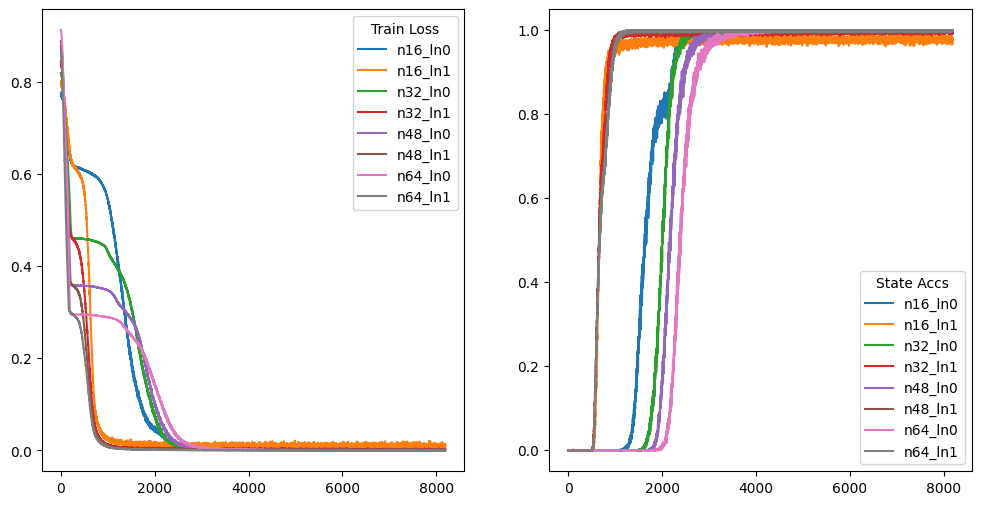

In [6]:
# Plot stuff
plt.clf()

fig, ax = plt.subplots(1, 2, figsize=(12,6))

for num_props in [16, 32, 48, 64]:
    for do_layer_norm in [False, True]:
        ln_str = "1" if do_layer_norm else "0"
        saveto = f"theory_n{num_props}_ln{ln_str}_ar{num_autoreg_steps}_bsz{batch_size}_ns{num_optim_steps}_lr{lr:.4f}.pt"
        save_dict = torch.load(saveto_dir + "/" + saveto)
        # try to load the model state dict just to make sure
        model = MyTheoryARModel(num_props, 3, do_layer_norm=do_layer_norm)
        model.load_state_dict(save_dict["model"])
        label = f"n{num_props}_ln{ln_str}"
        ax[0].plot(np.array(save_dict["losses"]), label=label)
        ax[1].plot(np.array(save_dict["state_accs"]), label=label)

ax[0].legend(loc="upper right", title="Train Loss")
ax[1].legend(loc="lower right", title="State Accs")